In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import defaultdict
from sklearn.metrics import mean_absolute_error

In [2]:
# 加载数据
with open(r"../1_Merge_full_snrg_catalog/SpecTE_Raw_Results.pkl", 'rb') as file:
    all_result = pickle.load(file)
len(all_result['te'][0])

23940

# 绘制参数估计精度和信噪比之间的关系图

In [3]:
# 加载数据
from collections import defaultdict
from sklearn.metrics import mean_absolute_error


# 加载数据
with open('StarGRUNet_Results.pkl', 'rb') as file:
    result1 = pickle.load(file)
    
with open('StarNet_Results.pkl', 'rb') as file:
    result2 = pickle.load(file)  
    
with open(r"../1_Merge_full_snrg_catalog/SpecTE_Raw_Results.pkl", 'rb') as file:
    result3 = pickle.load(file)    

legend_labels = {
    'result1': 'StarGRUNet',
    'result2': 'StarNet',
    'result3': 'SpecTE',
}  

No = 3
result = [result1,result2,result3] 

    
full_name_dict = {
    'te': r'$T_{\mathrm{eff}}$',
    'Lo': r'$\log g$',
    'RV':'RV',
    'Fe':'[Fe/H]',
    'Mg':'Mg/H',
    'Si':'Si/H',
    'SH':'S/H',
    'KH':'K/H',
    'Ca':'Ca/H',
    'Ti':'Ti/H',
    'Cr':'Cr/H',
    'Ni':'Ni/H',
    'CH':'C/H',
    'NH':'N/H',
    'OH':'O/H',
    'Al':'Al/H',
    'Mn':'Mn/H',
    'Na':'Na/H',
    'VH':'V/H',   
}    
# 读参数列表：
key_list=[]    
for key in result1:
    if key != 'snrg':
        key_list.append(key)
full_name_dict

{'te': '$T_{\\mathrm{eff}}$',
 'Lo': '$\\log g$',
 'RV': 'RV',
 'Fe': '[Fe/H]',
 'Mg': 'Mg/H',
 'Si': 'Si/H',
 'SH': 'S/H',
 'KH': 'K/H',
 'Ca': 'Ca/H',
 'Ti': 'Ti/H',
 'Cr': 'Cr/H',
 'Ni': 'Ni/H',
 'CH': 'C/H',
 'NH': 'N/H',
 'OH': 'O/H',
 'Al': 'Al/H',
 'Mn': 'Mn/H',
 'Na': 'Na/H',
 'VH': 'V/H'}

In [4]:
# 定义分组范围：
# groups = [(5, 10), (10, 15), (15, 20), (20, 30), (30,40), (40, 50), (50, 70), (70,100),(100, 150), (150, 200), (200, 999)]
groups = [(5, 10), (10, 15), (15, 20), (20, 30), (30,40), (40, 50), (50, 70), (70,100),(100,999)]

In [5]:
# 对数据分组：
# 创建用于存储分组数据的结构，每个分组是一个字典
group_results = list(range(No))
for i in range(No):
    group_results[i]={group: {key: [[], []] for key in all_result if key != 'snrg'} for group in groups}

    # 获取 snrg 数据
    snrg_values = result[i]['snrg'][0]

    # 对于每个分组，遍历 all_result 并按照 snrg 分组
    for idx, snrg in enumerate(snrg_values):
        # if idx % 20 == 0:
        #     print(idx)
        for group in groups:
            if group[0] <= snrg < group[1]:
                for key in result[i]:
                    # print(key)
                    if key != 'snrg':
                        group_results[i][group][key][0].append(result[i][key][0][idx])
                        group_results[i][group][key][1].append(result[i][key][1][idx])
                break

In [6]:
# 统计每组的σ、μ、MAE
diff_std = list(range(No))
diff_mean = list(range(No))
mae = list(range(No))

# 准备分组标签
# group_labels = [f"{group[0]}-{group[1]}" for group in groups]
group_labels=[]
for group in groups:
    if group[1]>500:
        group_labels.append(f"{group[0]}-"+r'$\infty$')
    else:    
        group_labels.append(f"{group[0]}-{group[1]}")

for i in range(No):
    # 为每个组初始化空列表
    diff_std[i] = {group: [] for group in groups}
    diff_mean[i] = {group: [] for group in groups}
    mae[i] = {group: [] for group in groups}

    # 对每个组计算统计值
    for group, data in group_results[i].items():
        for key, (pred, true) in data.items():
            if pred and true:
                # 确保pred和true为NumPy数组
                pred = np.array(pred)
                true = np.array(true)

                diff = pred - true
                # diff_std_values.append(diff.std(axis=0))
                # diff_mean_values.append(diff.mean(axis=0))
                # mae_values.append(mean_absolute_error(true, pred))
                # 添加统计值到对应的分组
                diff_std[i][group].append(np.std(diff, ddof=1) if diff.size > 1 else np.nan)
                diff_mean[i][group].append(np.mean(diff) if diff.size > 0 else np.nan)
                mae[i][group].append(mean_absolute_error(true, pred) if true.size > 0 else np.nan)

In [7]:
final_indicator = [[]] * No
(final_indicator[0]).append(1)
(final_indicator[1]).append(2)
final_indicator

[[1, 2], [1, 2], [1, 2]]

### MAE

C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_26696\677818588.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, fontsize=15)


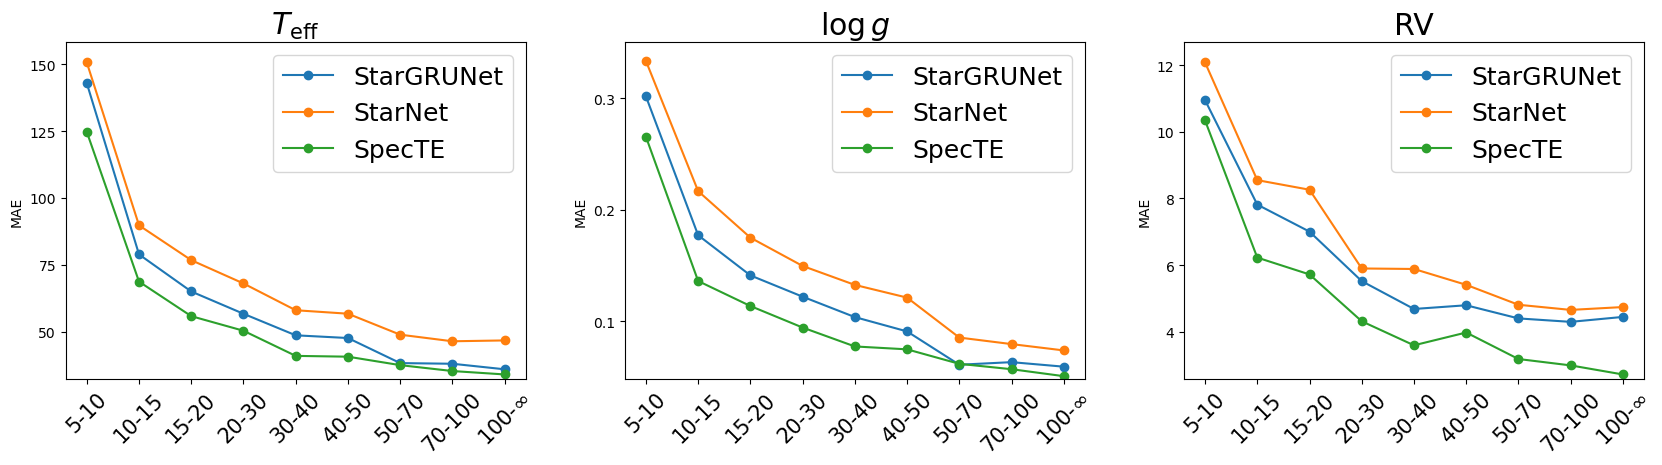

In [8]:
# MAE

N = 3  # 例如，您有15个不同的参数
rows = (N + 2) // 3  # 计算行数，假设每行2个图，+1是为了确保余数也能形成一行

# 创建一个大图，其中包含多个子图
fig, axes = plt.subplots(rows, 3, figsize=(17, 5))  # 宽度15英寸，每个子图的高度大约为5英寸   原来18：5

# 设置全局字体大小
plt.rcParams.update({'font.size': 18})  # 全局字体设置
# plt.rcParams.update({
#     "text.usetex": True,
#     "text.latex.preamble": r"\usepackage{amsmath}"
# })
plt.rcParams.update({
    "text.usetex": False
})

# fig.suptitle(r'S/$N_{g}$ Analysis_MAE', fontsize=24, y=0.995)

# 遍历每个参数，创建相应的子图
for i in range(3):
    
    row = i // 3  # 计算当前参数应该在哪一行
    
    
    col = i % 3   # 计算当前参数应该在哪一列
    ax = axes[i]
    final_indicator = [[] for _ in range(No)]
    
    # 读取数据
    for z in range(No):
        for group in groups:
            # 读取分组中代表Teff的值；如果没有，则使用NaN
            final_indicator[z].append(mae[z][group][i] if mae[z][group][i] else np.nan)
            
    min_indicator = np.inf
    max_indicator = 0
    # 对当前参数画折线图
    for z in range(No):
        ax.plot(group_labels, final_indicator[z], 'o-', label= legend_labels[f'result{z+1}'])
        min_indicator = min(min_indicator,min(final_indicator[z]))
        max_indicator = max(max_indicator,max(final_indicator[z]))

    ax.set_ylabel("MAE")
    ax.set_title(f'{full_name_dict[key_list[i]]}')
    ax.legend()
    ax.set_xticklabels(group_labels, rotation=45, fontsize=15)
    ax.set_ylim([min_indicator*0.95, max_indicator*1.05])  

# 关闭不需要的子图轴
for j in range(N, rows * 3):
    fig.delaxes(axes.flatten()[j])    
    
# 调整布局以避免剪裁
plt.tight_layout()

# 图表保存路径
save_path = './snrg_SpecTE_Star_StatGRU_MAE_onle3.png'
# 保存图表
plt.savefig(save_path)
save_path_pdf = './snrg_SpecTE_Star_StatGRU_MAE_onle3.pdf'
plt.savefig(save_path_pdf, format='pdf')

# 显示图表
plt.show()

C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_26696\2991426127.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, fontsize=15)


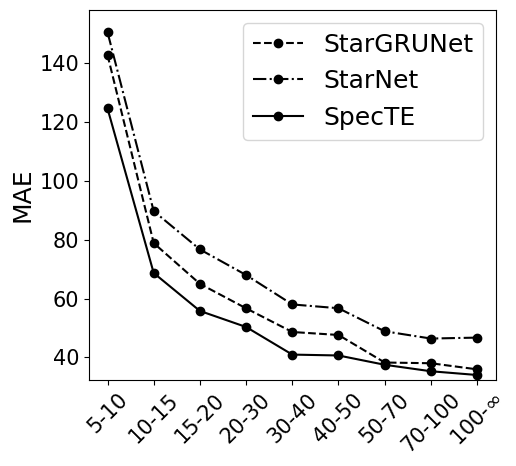

C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_26696\2991426127.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, fontsize=15)


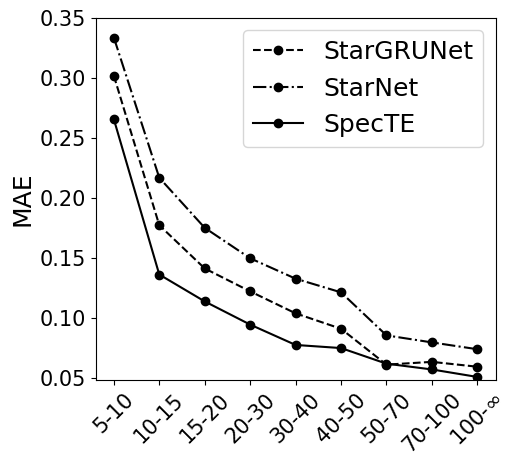

C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_26696\2991426127.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, fontsize=15)


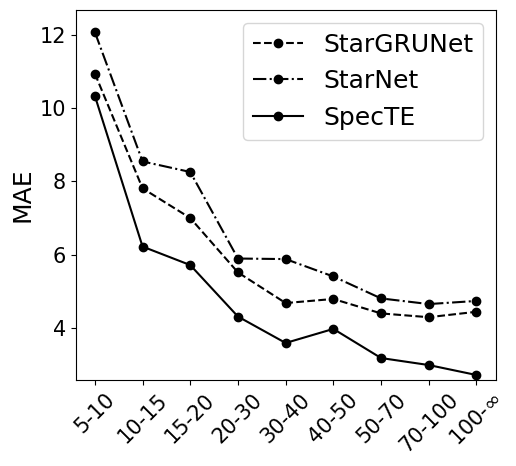

C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_26696\2991426127.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, fontsize=15)


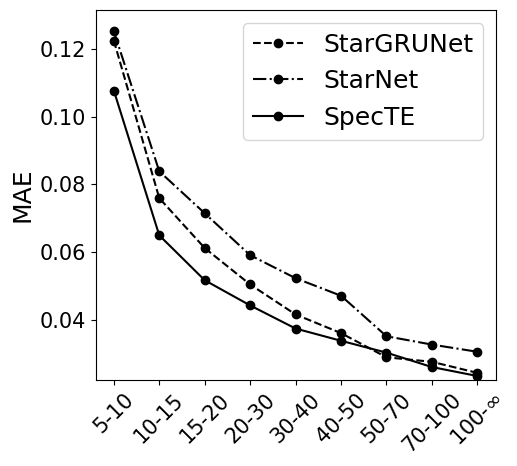

In [12]:
## 用不同线型来区分

# 设置全局字体大小
plt.rcParams.update({'font.size': 18})  # 全局字体设置
plt.rcParams.update({
    "text.usetex": False
})


N = 3  # 参数数量
line_styles = [ '--', '-.','-',] 

# 遍历每个参数，创建相应的图表
for i in range(4):
    # 创建一个新的图和轴，每个图的大小为 (5, 5)
    fig, ax = plt.subplots(figsize=(5.5, 5))

    final_indicator = [[] for _ in range(No)]

    # 读取数据
    for z in range(No):
        for group in groups:
            # 读取分组中代表 Teff 的值；如果没有，则使用 NaN
            value = mae[z][group][i] if mae[z][group][i] else np.nan
            final_indicator[z].append(value)

    min_indicator = np.inf
    max_indicator = 0

    # # 对当前参数画折线图
    # for z in range(No):
    #     ax.plot(group_labels, final_indicator[z], 'o-', label=legend_labels[f'result{z+1}'])
    #     min_indicator = min(min_indicator, min(final_indicator[z]))
    #     max_indicator = max(max_indicator, max(final_indicator[z]))
    for z in range(No):
        ax.plot(
            group_labels,
            final_indicator[z],
            linestyle=line_styles[z],      # 设置线型
            marker='o',                     # 保留标记
            # color='black',               #  设置所有线条为黑色
            label=legend_labels[f'result{z+1}']
        )
        min_indicator = min(min_indicator, np.nanmin(final_indicator[z]))
        max_indicator = max(max_indicator, np.nanmax(final_indicator[z]))


    # 设置标签和标题
    ax.set_ylabel("MAE")
    # ax.set_title(f'{full_name_dict[key_list[i]]}')
    ax.legend()
    ax.set_xticklabels(group_labels, rotation=45, fontsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylim([min_indicator * 0.95, max_indicator * 1.05])

    # 调整布局以避免剪裁
    plt.tight_layout()

    # 图表保存路径，命名为 figure_1.png, figure_2.png, figure_3.png
    save_path = f'./MAE_snrg/figure_{i+1}.png'
    plt.savefig(save_path)
    save_path_pdf = f'./MAE_snrg/figure_{i+1}.pdf'
    plt.savefig(save_path_pdf, format='pdf',bbox_inches='tight')

    # 显示图表
    plt.show()


C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_20192\1987024538.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, fontsize=15)


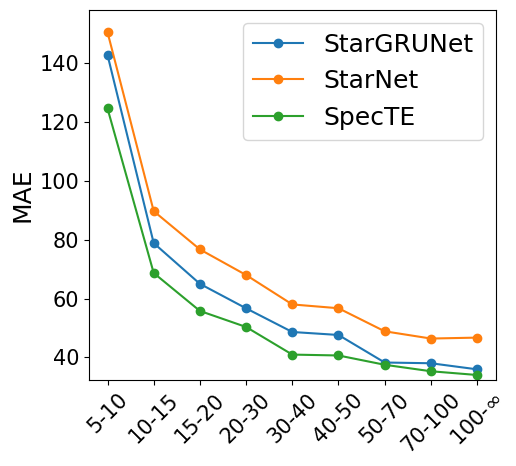

C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_20192\1987024538.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, fontsize=15)


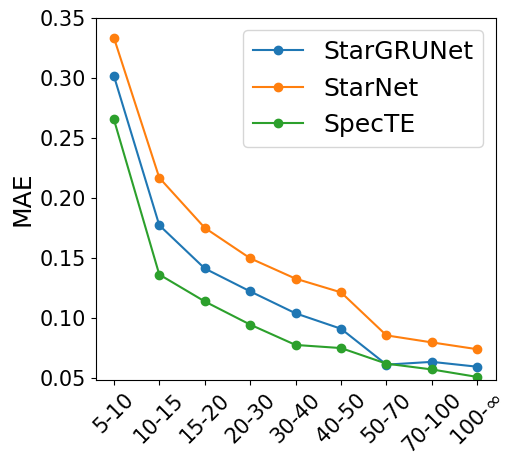

C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_20192\1987024538.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, fontsize=15)


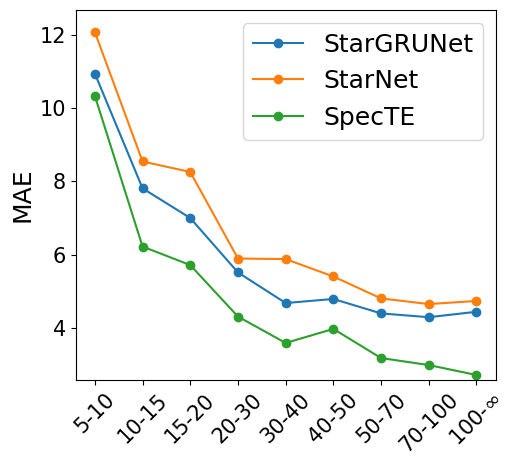

C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_20192\1987024538.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, fontsize=15)


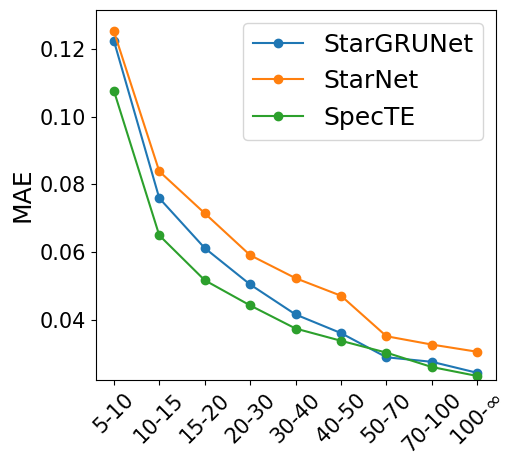

In [9]:
# 设置全局字体大小
plt.rcParams.update({'font.size': 18})  # 全局字体设置
plt.rcParams.update({
    "text.usetex": False
})


N = 3  # 参数数量
# No = ...  # 数据集数量
# groups = [...]  # 分组列表
# group_labels = [...]  # 分组标签列表
# mae = [...]  # 存储 MAE 值的列表
# legend_labels = {...}  # 图例标签字典
# full_name_dict = {...}  # 参数全名字典
# key_list = [...]  # 参数键列表

# 遍历每个参数，创建相应的图表
for i in range(4):
    # 创建一个新的图和轴，每个图的大小为 (5, 5)
    fig, ax = plt.subplots(figsize=(5.5, 5))

    final_indicator = [[] for _ in range(No)]

    # 读取数据
    for z in range(No):
        for group in groups:
            # 读取分组中代表 Teff 的值；如果没有，则使用 NaN
            value = mae[z][group][i] if mae[z][group][i] else np.nan
            final_indicator[z].append(value)

    min_indicator = np.inf
    max_indicator = 0

    # 对当前参数画折线图
    for z in range(No):
        ax.plot(group_labels, final_indicator[z], 'o-', label=legend_labels[f'result{z+1}'])
        min_indicator = min(min_indicator, min(final_indicator[z]))
        max_indicator = max(max_indicator, max(final_indicator[z]))

    # 设置标签和标题
    ax.set_ylabel("MAE")
    # ax.set_title(f'{full_name_dict[key_list[i]]}')
    ax.legend()
    ax.set_xticklabels(group_labels, rotation=45, fontsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylim([min_indicator * 0.95, max_indicator * 1.05])

    # 调整布局以避免剪裁
    plt.tight_layout()

    # 图表保存路径，命名为 figure_1.png, figure_2.png, figure_3.png
    save_path = f'./MAE_snrg/figure_{i+1}.png'
    plt.savefig(save_path)
    save_path_pdf = f'./MAE_snrg/figure_{i+1}.pdf'
    plt.savefig(save_path_pdf, format='pdf',bbox_inches='tight')

    # 显示图表
    plt.show()


C:\Users\ZhaoXR\AppData\Local\Temp\ipykernel_20192\1380267473.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, fontsize=15)


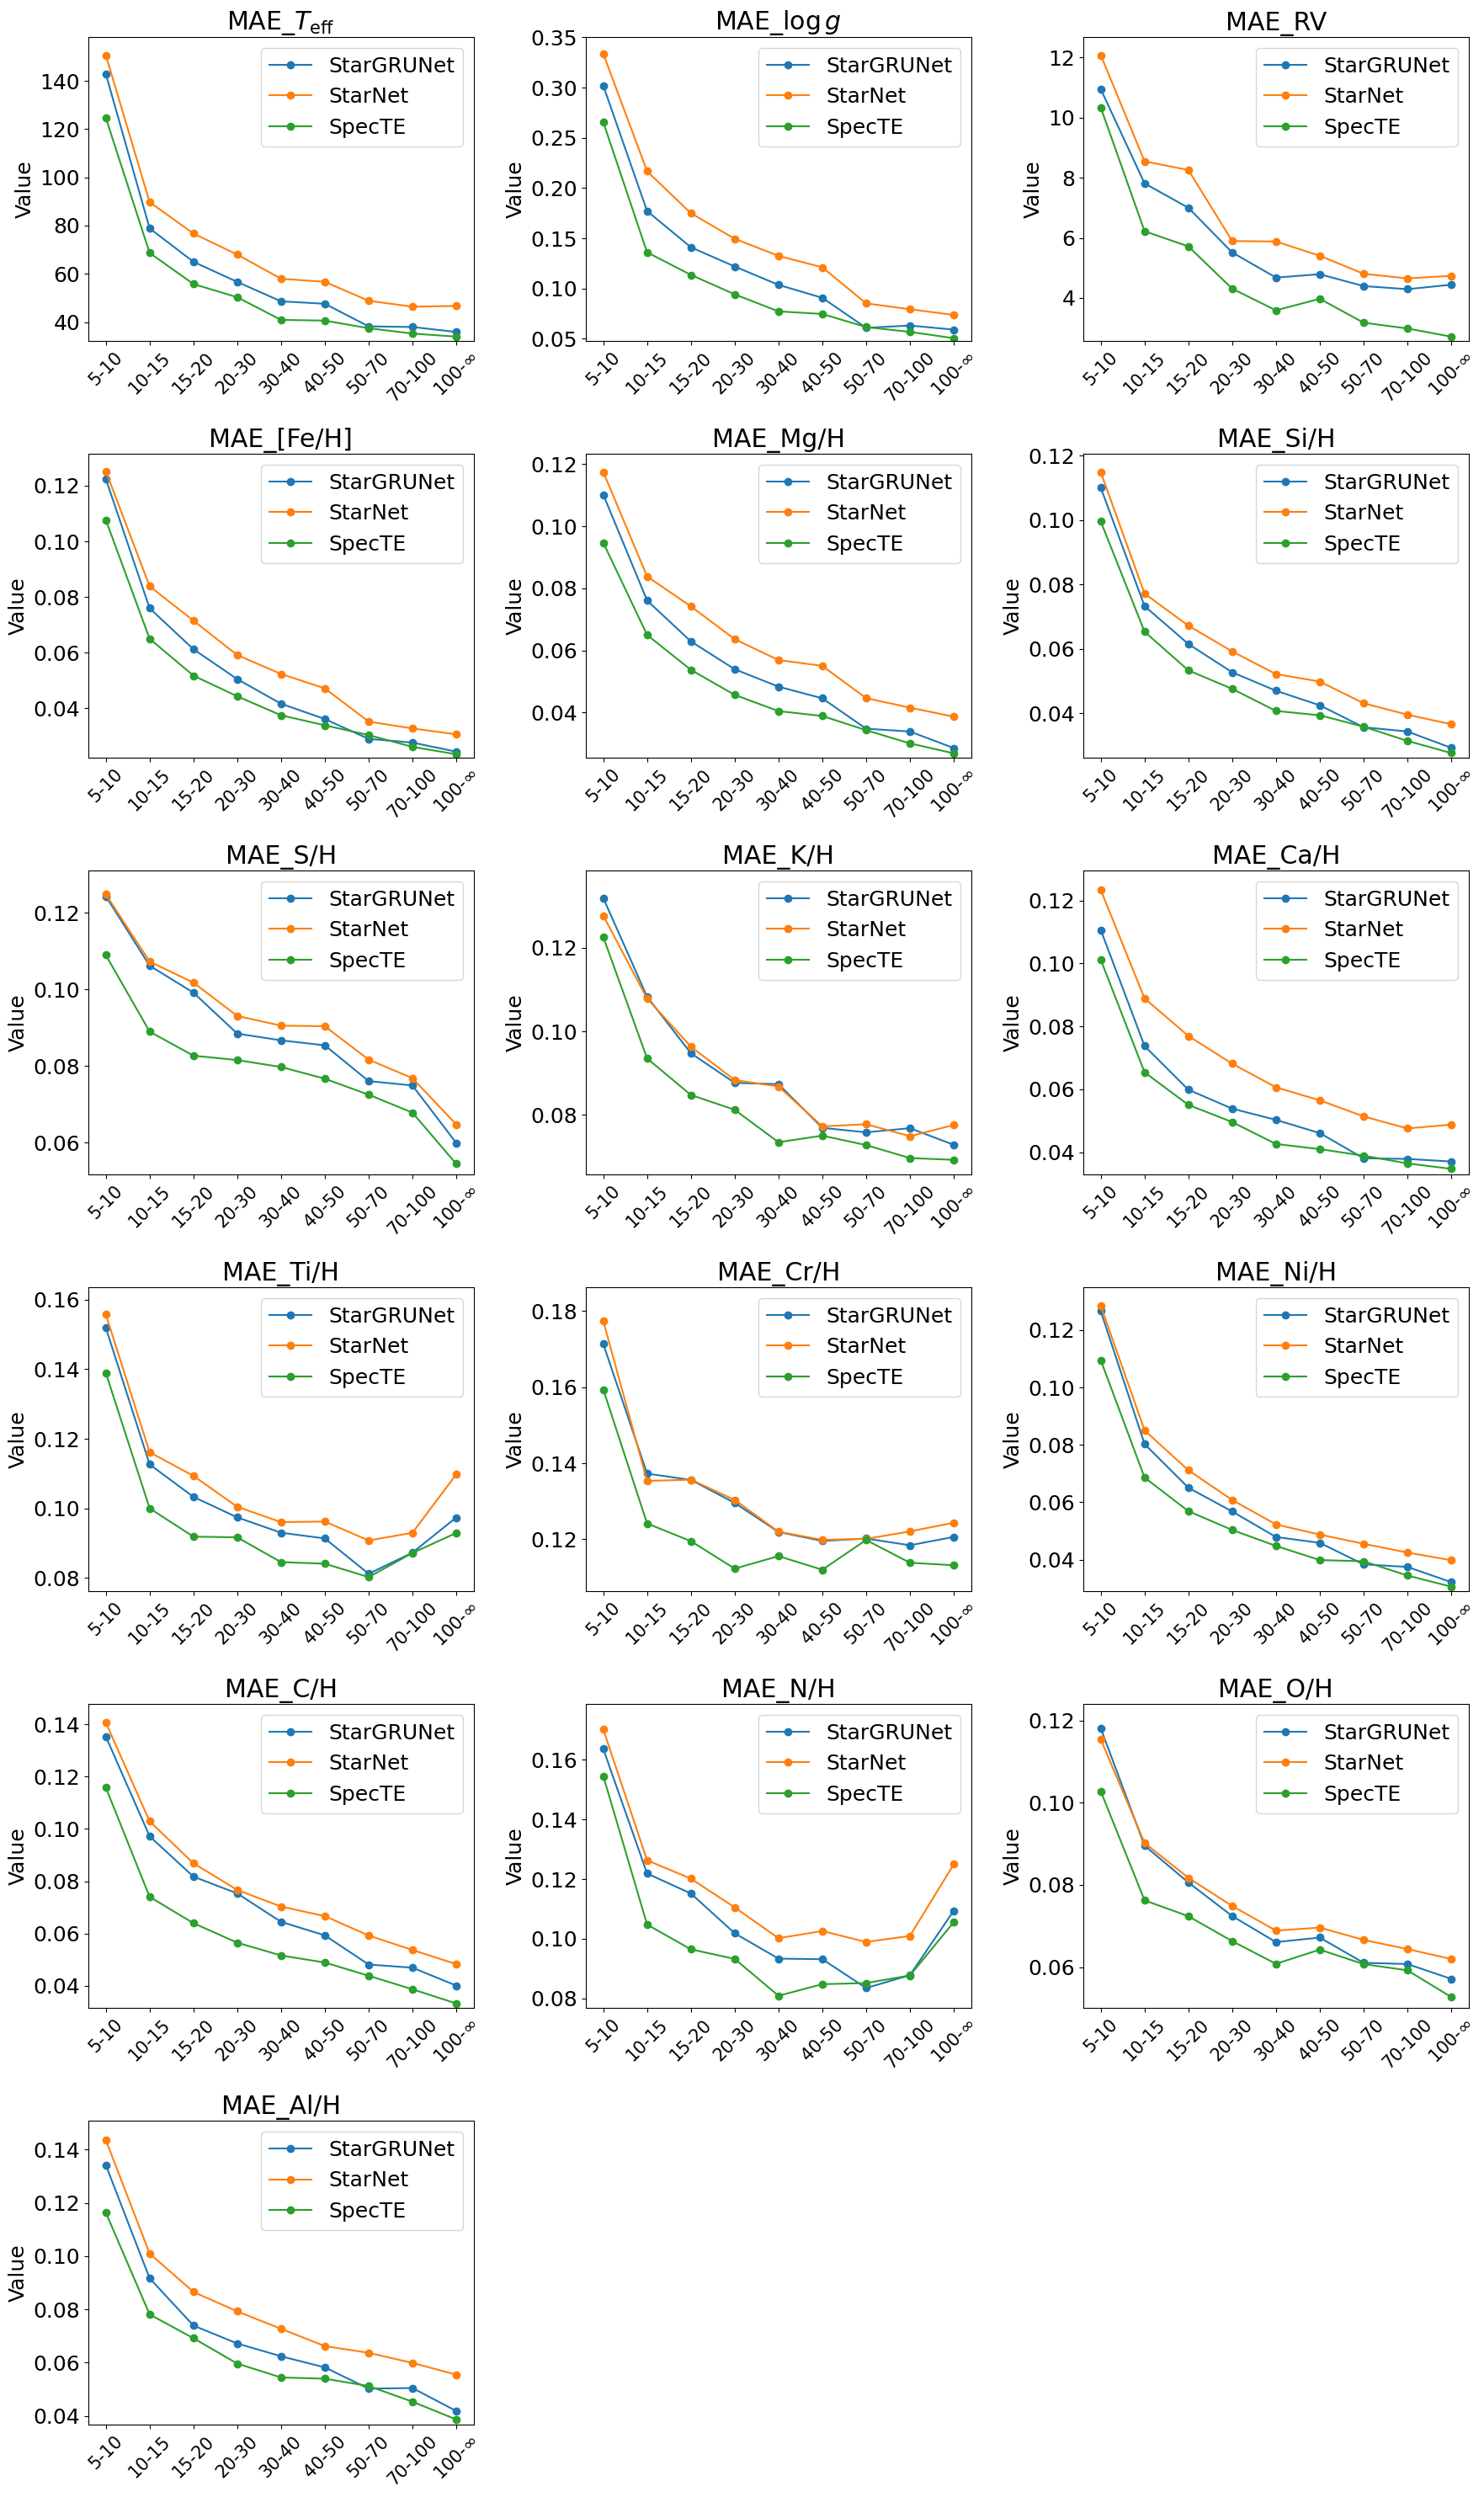

In [10]:
# MAE

N = 16  # 例如，您有15个不同的参数
rows = (N + 2) // 3  # 计算行数，假设每行2个图，+1是为了确保余数也能形成一行

# 创建一个大图，其中包含多个子图
fig, axes = plt.subplots(rows, 3, figsize=(18, 30))  # 宽度15英寸，每个子图的高度大约为5英寸

# 设置全局字体大小
plt.rcParams.update({'font.size': 18})  # 全局字体设置

# fig.suptitle(r'S/$N_{g}$ Analysis_MAE', fontsize=24, y=0.995)

# 遍历每个参数，创建相应的子图
for i in range(16):
    
    row = i // 3  # 计算当前参数应该在哪一行
    
    
    col = i % 3   # 计算当前参数应该在哪一列
    ax = axes[row, col]  # 获取对应的子图轴对象
    
    final_indicator = [[] for _ in range(No)]
    # 读取数据
    for z in range(No):
        for group in groups:
            # 读取分组中代表Teff的值；如果没有，则使用NaN
            final_indicator[z].append(mae[z][group][i] if mae[z][group][i] else np.nan)
            
    min_indicator = np.inf
    max_indicator = 0
    # 对当前参数画折线图
    for z in range(No):
        ax.plot(group_labels, final_indicator[z], 'o-', label= legend_labels[f'result{z+1}'])
        min_indicator = min(min_indicator,min(final_indicator[z]))
        max_indicator = max(max_indicator,max(final_indicator[z]))

    # # 标值
    # for j, (std, mean, mae) in enumerate(zip(final_diff_std_values, final_diff_mean_values, final_mae_values)):
    #     ax.text(j, std, f'{std:.3f}', ha='center', va='bottom', fontsize=8)
    #     ax.text(j, mean, f'{mean:.2f}', ha='center', va='bottom', fontsize=8)
    #     ax.text(j, mae, f'{mae:.2f}', ha='center', va='bottom', fontsize=8)

    # ax.set_xlabel('Group')
    ax.set_ylabel('Value')
    ax.set_title("MAE_"+f'{full_name_dict[key_list[i]]}')
    ax.legend()
    ax.set_xticklabels(group_labels, rotation=45, fontsize=15)
    ax.set_ylim([min_indicator*0.95, max_indicator*1.05])  

# 关闭不需要的子图轴
for j in range(N, rows * 3):
    fig.delaxes(axes.flatten()[j])    
    
# 调整布局以避免剪裁
plt.tight_layout()

# 图表保存路径
save_path = './snrg_SpecTE_Star_StatGRU_MAE.png'
# 保存图表
plt.savefig(save_path)

# 显示图表
plt.show()

### σ

In [ ]:
# σ
# diff_std = list(range(No))
# diff_mean = list(range(No))
N = 17 
rows = (N + 2) // 3  # 计算行数，假设每行2个图，+1是为了确保余数也能形成一行

# 创建一个大图，其中包含多个子图
fig, axes = plt.subplots(rows, 3, figsize=(18, 30))  # 宽度15英寸，每个子图的高度大约为5英寸

# 设置全局字体大小
plt.rcParams.update({'font.size': 18})  # 全局字体设置

# fig.suptitle(r'S/$N_{g}$ Analysis_σ', fontsize=24, y=0.995)

# 遍历每个参数，创建相应的子图
for i in range(16):
    row = i // 3  # 计算当前参数应该在哪一行
    col = i % 3   # 计算当前参数应该在哪一列
    ax = axes[row, col]  # 获取对应的子图轴对象
    
    final_indicator = [[] for _ in range(No)]
    # 读取数据
    for z in range(No):
        for group in groups:
            # 读取分组中代表Teff的值；如果没有，则使用NaN
            final_indicator[z].append(diff_std[z][group][i] if diff_std[z][group][i] else np.nan)
    min_indicator = np.inf
    max_indicator = 0
    # 对当前参数画折线图
    for z in range(No):
        ax.plot(group_labels, final_indicator[z], 'o-', label= legend_labels[f'result{z+1}'])
        min_indicator = min(min_indicator,min(final_indicator[z]))
        max_indicator = max(max_indicator,max(final_indicator[z]))


    # # 标值
    # for j, (std, mean, mae) in enumerate(zip(final_diff_std_values, final_diff_mean_values, final_mae_values)):
    #     ax.text(j, std, f'{std:.3f}', ha='center', va='bottom', fontsize=8)
    #     ax.text(j, mean, f'{mean:.2f}', ha='center', va='bottom', fontsize=8)
    #     ax.text(j, mae, f'{mae:.2f}', ha='center', va='bottom', fontsize=8)

    # ax.set_xlabel('Group')
    ax.set_ylabel('Value')
    ax.set_title("σ_"+f'{full_name_dict[key_list[i]]}')
    ax.legend()
    ax.set_xticklabels(group_labels, rotation=45, fontsize=15)
    ax.set_ylim([min_indicator*0.95, max_indicator*1.05])  

# 关闭不需要的子图轴
for j in range(N, rows * 3):
    fig.delaxes(axes.flatten()[j])    
    
# 调整布局以避免剪裁
plt.tight_layout()

# 图表保存路径
save_path = './snrg_SpecTE_Star_StatGRU_σ.png'
# 保存图表
plt.savefig(save_path)

# 显示图表
plt.show()

### μ

In [ ]:
# μ
# diff_std = list(range(No))
# diff_mean = list(range(No))


rows = (N + 2) // 3  # 计算行数，假设每行2个图，+1是为了确保余数也能形成一行

# 创建一个大图，其中包含多个子图
fig, axes = plt.subplots(rows, 3, figsize=(18, 30))  # 宽度15英寸，每个子图的高度大约为5英寸

fig.suptitle('SNRg Analysis_μ', fontsize=24, y=1.02)

# 遍历每个参数，创建相应的子图
for i in range(16):
    row = i // 3  # 计算当前参数应该在哪一行
    col = i % 3   # 计算当前参数应该在哪一列
    ax = axes[row, col]  # 获取对应的子图轴对象
    
    final_indicator = [[] for _ in range(No)]
    # 读取数据
    for z in range(No):
        for group in groups:
            # 读取分组中代表Teff的值；如果没有，则使用NaN
            final_indicator[z].append(abs(diff_mean[z][group][i] if diff_mean[z][group][i] else np.nan))
            
    min_indicator = np.inf
    max_indicator = 0
    # 对当前参数画折线图
    for z in range(No):
        ax.plot(group_labels, final_indicator[z], 'o-', label= legend_labels[f'result{z+1}'])
        min_indicator = min(min_indicator,min(final_indicator[z]))
        max_indicator = max(max_indicator,max(final_indicator[z]))
    # # 标值
    # for j, (std, mean, mae) in enumerate(zip(final_diff_std_values, final_diff_mean_values, final_mae_values)):
    #     ax.text(j, std, f'{std:.3f}', ha='center', va='bottom', fontsize=8)
    #     ax.text(j, mean, f'{mean:.2f}', ha='center', va='bottom', fontsize=8)
    #     ax.text(j, mae, f'{mae:.2f}', ha='center', va='bottom', fontsize=8)

    # ax.set_xlabel('Group')
    ax.set_ylabel('Value')
    ax.set_title("μ_"+f'{full_name_dict[key_list[i]]}')
    ax.legend()
    ax.set_xticklabels(group_labels, rotation=45)
    ax.set_ylim([min_indicator*0.95, max_indicator*1.05])  

# 关闭不需要的子图轴
for j in range(N, rows * 3):
    fig.delaxes(axes.flatten()[j])    
    
# 调整布局以避免剪裁
plt.tight_layout()

# 图表保存路径
save_path = './snrg比较多种方法μ.png'
# 保存图表
plt.savefig(save_path)

# 显示图表
plt.show()